In [48]:
import os
import pickle
import joblib
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix



# Downloading the data

In [49]:
TITANIC_ROOT = os.path.join("datasets", "databases")
MODELS_ROOT = os.path.join("models", "best_model")
PIPELINE_ROOT = os.path.join("models", "pipeline")
os.makedirs(TITANIC_ROOT, exist_ok=True)
os.makedirs(MODELS_ROOT, exist_ok=True)
os.makedirs("graphs", exist_ok=True)

!kaggle competitions download -c titanic -p {TITANIC_ROOT}

titanic_zip = os.path.join(TITANIC_ROOT, "titanic.zip")
with zipfile.ZipFile(titanic_zip, 'r') as zip_ref:
    zip_ref.extractall(TITANIC_ROOT)

os.remove(titanic_zip)

print(f"Files in directory: {os.listdir(TITANIC_ROOT)}")

Files in directory: ['gender_submission.csv', 'test.csv', 'train.csv']


# Preprocessing Class

In [50]:
from abc import ABC, abstractmethod

class Preprocessing(ABC):
    def __init__(self, titanic_path=TITANIC_ROOT):
        train_csv_path = os.path.join(titanic_path, "train.csv")
        test_csv_path = os.path.join(titanic_path, "test.csv")
        self.train = pd.read_csv(train_csv_path)
        self.test = pd.read_csv(test_csv_path)
        self.deleting_columns()
        self.numeric_columns_train = self.train.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_train = self.train.select_dtypes(exclude=['int64', 'float64'])
        self.numeric_columns_test = self.test.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_test = self.test.select_dtypes(exclude=['int64', 'float64'])

    def deleting_columns(self):
        # Dropping the PassengerId and Name columns from train dataset and test dataset as well
        self.train.drop(columns=["PassengerId", "Name"], inplace=True)
        self.test.drop(columns=["PassengerId", "Name"], inplace=True)


    @abstractmethod
    def inconsistent_data(self):
        pass

    @abstractmethod
    def missing_data(self):
        pass


# Train Dataset

In [51]:
class TrainPreprocessing(Preprocessing):
    def __init__(self):
        super().__init__()
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_val = None
        self.y_val = None

    # Verifying missing data
    def missing_data(self):
        print("Missing data: ")
        print(self.train.isnull().sum())

    # Verifying inconsistent values
    def inconsistent_data(self):
        for column in self.numeric_columns_train.columns:
            inconsistent_values = self.train.loc[self.train[column] < 0]
            if inconsistent_values.empty:
                print(f"Column {column} has no inconsistent values")
            else:
                print(f"Column {column} has inconsistent values")

        return self.train

    def histogram_graphs(self):
        self.train.hist(bins=50, figsize=(20, 15), color="red")
        plt.tight_layout()
        plt.savefig(os.path.join("graphs", "histogram.png"))
        plt.show()

    def correlation_matrix(self):
        correlation_matrix = self.numeric_columns_train.corr()
        survived_correlation = correlation_matrix["Survived"].sort_values(ascending=False)
        print(survived_correlation)

        plt.figure(figsize = (10, 8))
        survived_correlation.plot(kind="bar", color="red")
        plt.xlabel('Features')
        plt.ylabel('Correlation')
        plt.savefig(os.path.join("graphs", "correlation_matrix.png"))
        plt.show()

    def dynamic_graph(self):
        graph = px.scatter_matrix(self.train, dimensions=["Survived", "Fare", "Pclass"], color="Survived")
        graph.show()

    def boxplots_graphs(self):
        for feature in self.numeric_columns_train.columns:
            graph = px.box(self.train, y=feature)
            graph.show()

    def removing_outliers(self):
        outliers_columns = ["Fare", "SibSp"]
        for column in outliers_columns:
            q1 = self.train[column].quantile(0.25)
            q3 = self.train[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            self.train = self.train[(self.train[column] >= lower_bound) & (self.train[column] <= upper_bound)]

    def splitting_data(self):
        self.X = self.train[["Pclass", "Sex", "Age", "Fare"]]
        self.y = self.train["Survived"]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.2, random_state=42)

        split_datasets_path = os.path.join("datasets", "split_datasets")
        os.makedirs(split_datasets_path, exist_ok=True)

        # Saving the datasets
        try:
            with open(os.path.join(split_datasets_path, "split_datasets.pkl"), "wb") as file:
                pickle.dump([self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test], file)
        except Exception as e:
            print(f"Could not save split datasets: {e}")


    # Pipelines for numeric attributes
    def pipelines_transformation(self):
        num_pipelines = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('std_scaler', StandardScaler()),
        ])

        cat_pipelines = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('one_hot', OneHotEncoder(drop='first', sparse_output=False)),
        ])

        # Combined both pipelines
        combined_pipelines = ColumnTransformer([
            ('num', num_pipelines, self.numeric_columns_train.columns),
            ('cat', cat_pipelines, self.categorical_columns_train.columns),
        ])

        # Fit and transform the train set
        self.X_train = combined_pipelines.fit_transform(self.X_train)

        # Transform test and validation sets
        self.X_val = combined_pipelines.transform(self.X_val)
        self.X_test = combined_pipelines.transform(self.X_test)

        # Saving the pipeline
        try:
            os.makedirs(PIPELINE_ROOT, exist_ok=True)
            joblib.dump(combined_pipelines, os.path.join(PIPELINE_ROOT, "pipeline.pkl"))
            print("Pipeline has been saved")
        except Exception as e:
            print(f"Error saving the pipeline: {e}")

    def update_columns_type(self):
        self.numeric_columns_train = self.X_train.select_dtypes(include=["int64", "float64"])
        self.categorical_columns_train = self.X_train.select_dtypes(exclude=["int64", "float64"])

# Training models

In [52]:
class Train(TrainPreprocessing, ABC):
    @abstractmethod
    def train_model(self):
        pass

    def load_split_datasets(self):
        if os.path.exists('datasets/split_datasets/split_datasets.pkl'):
            with open('datasets/split_datasets/split_datasets.pkl', 'rb') as file:
                self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = pickle.load(file)
        else:
            raise FileNotFoundError("Database was not found. \n")

    def load_pipeline(self):
        try:
            with open("models/pipeline/pipeline.pkl", "rb") as file:
                pipeline = joblib.load(file)
                return pipeline

        except Exception as e:
            print(f"Could not load the pipeline: {e}")



    # Evaluating different models using cross validation
    def evaluate_models(self):
        self.load_split_datasets()

        # Loading the pipeline trained
        pipeline_path = os.path.join(PIPELINE_ROOT, "pipeline.pkl")
        if os.path.exists(pipeline_path):
            with open(pipeline_path, 'rb') as file:
                pipeline = joblib.load(file)
        else:
            raise FileNotFoundError("Could not load the pipeline")


        X = pipeline.transform(pd.concat([self.X_train, self.X_val, self.X_test]))
        y = pd.concat([self.y_train, self.y_val, self.y_test])

        models = [
            LogisticRegression(),
            KNeighborsClassifier(),
            SVC(probability=True),
            RandomForestClassifier(),
        ]
        results = []

        for model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

            scores = model_selection.cross_val_score(model, X, y, scoring="roc_auc", cv=kfold)
            results.append({
                "Model": model.__class__.__name__,
                "AUC Mean": round(scores.mean(), 3),
                "AUC Std": round(scores.std(), 2),
            })

        results_df = pd.DataFrame(results)
        display(results_df.sort_values(by="AUC Mean", ascending=False).reset_index(drop=True))


class TrainRFC(Train):
    def __init__(self):
        super().__init__()
        self.X_train_transformed = None
        self.X_test_transformed = None


    def train_model(self):
        self.load_split_datasets()
        pipeline = self.load_pipeline()

        self.X_train_transformed = pipeline.transform(self.X_train)
        self.X_test_transformed = pipeline.transform(self.X_test)


        random_forest = RandomForestClassifier(bootstrap=True, class_weight=None,
                                               criterion="gini", random_state=42, verbose=0,
                                               n_estimators=200, max_features="sqrt", min_samples_leaf=0.1)

        random_forest.fit(self.X_train_transformed, self.y_train)

        with open("models/random_forest.pkl", "wb") as file:
            pickle.dump(random_forest, file)

        prediction = random_forest.predict(self.X_test_transformed)
        accuracy = random_forest.score(self.X_test_transformed, self.y_test)
        precision = precision_score(self.y_test, prediction)

        return accuracy, precision

    def get_important_features(self):
        try:
            with open("models/random_forest.pkl", "rb") as file:
                random_forest = pickle.load(file)

            pipeline = self.load_pipeline()

            feature_names = []
            for name, transformer, columns in pipeline.transformers_:
                if isinstance(transformer, Pipeline):
                    last_step = transformer.steps[-1][-1]
                    if hasattr(last_step, "get_feature_names"):
                        transformed_names = last_step.get_feature_names_out(columns)
                        feature_names.extend(transformed_names)
                    else:
                        feature_names.extend(columns)
                elif hasattr(transformer, "get_feature_names_out"):
                    transformed_names = transformer.get_feature_names_out(columns)
                    feature_names.extend(transformed_names)
                else:
                    feature_names.extend(columns)

            importances = random_forest.feature_importances_
            feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1],
                                         reverse=True)[:5]
            for name, importance in feature_importances:
                print(f"{name:30}: {importance:.3f}")


        except Exception as e:
            print(f"Could not load the random forest model: {e}")

    def select_best_hyperparameters(self):
        random_forest = RandomForestClassifier()
        params = {
            "max_features": [0.4, "sqrt", "log2", 0.6],
            "n_estimators": [100, 200, 300, 400, 500],
            "min_samples_leaf": [1, 0.1],
        }

        cross_validation = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = model_selection.GridSearchCV(estimator=random_forest, param_grid=params,
                                                        scoring="roc_auc", cv=cross_validation,
                                                        n_jobs=-1, verbose=1)
        grid_search.fit(self.X_train_transformed, self.y_train)
        print(f"Best hyperparameters: {grid_search.best_params_}")


        with open("models/best_model/random_forest_best_model.pkl", "wb") as file:
            pickle.dump(grid_search.best_estimator_, file)

    def evaluate_best_random_forest_model(self):
        self.load_split_datasets()
        pipeline = self.load_pipeline()
        X_test_transformed = pipeline.transform(self.X_test)

        try:
            with open("models/best_model/random_forest_best_model.pkl", "rb") as file:
                best_random_forest = pickle.load(file)
            y_pred = best_random_forest.predict(self.X_test_transformed)
            accuracy = best_random_forest.score(X_test_transformed, self.y_test)
            precision = precision_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            roc_auc = roc_auc_score(self.y_test, best_random_forest.predict_proba(X_test_transformed)[:, 1])

            print(f"Accuracy : {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall   : {recall:.4f}")
            print(f"AUC      : {roc_auc:.4f}")

            confusion_matrix(self.y_test, y_pred)
            confusion_matrix_viz = ConfusionMatrix(best_random_forest, class_names=["died", "survived"])
            confusion_matrix_viz.score(X_test_transformed, self.y_test)
            confusion_matrix_viz.show(outpath="graphs/confusion_matrix.png")

        except Exception as e:
            print(f"Could not load the best random forest model: {e}")


class SvcModel(Train):
    def train_model(self):
        self.load_split_datasets()

In [53]:
preprocessing = TrainPreprocessing()
preprocessing.train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,male,54.0,0,0,17463,51.8625,E46,S
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,female,14.0,1,0,237736,30.0708,NaN,C


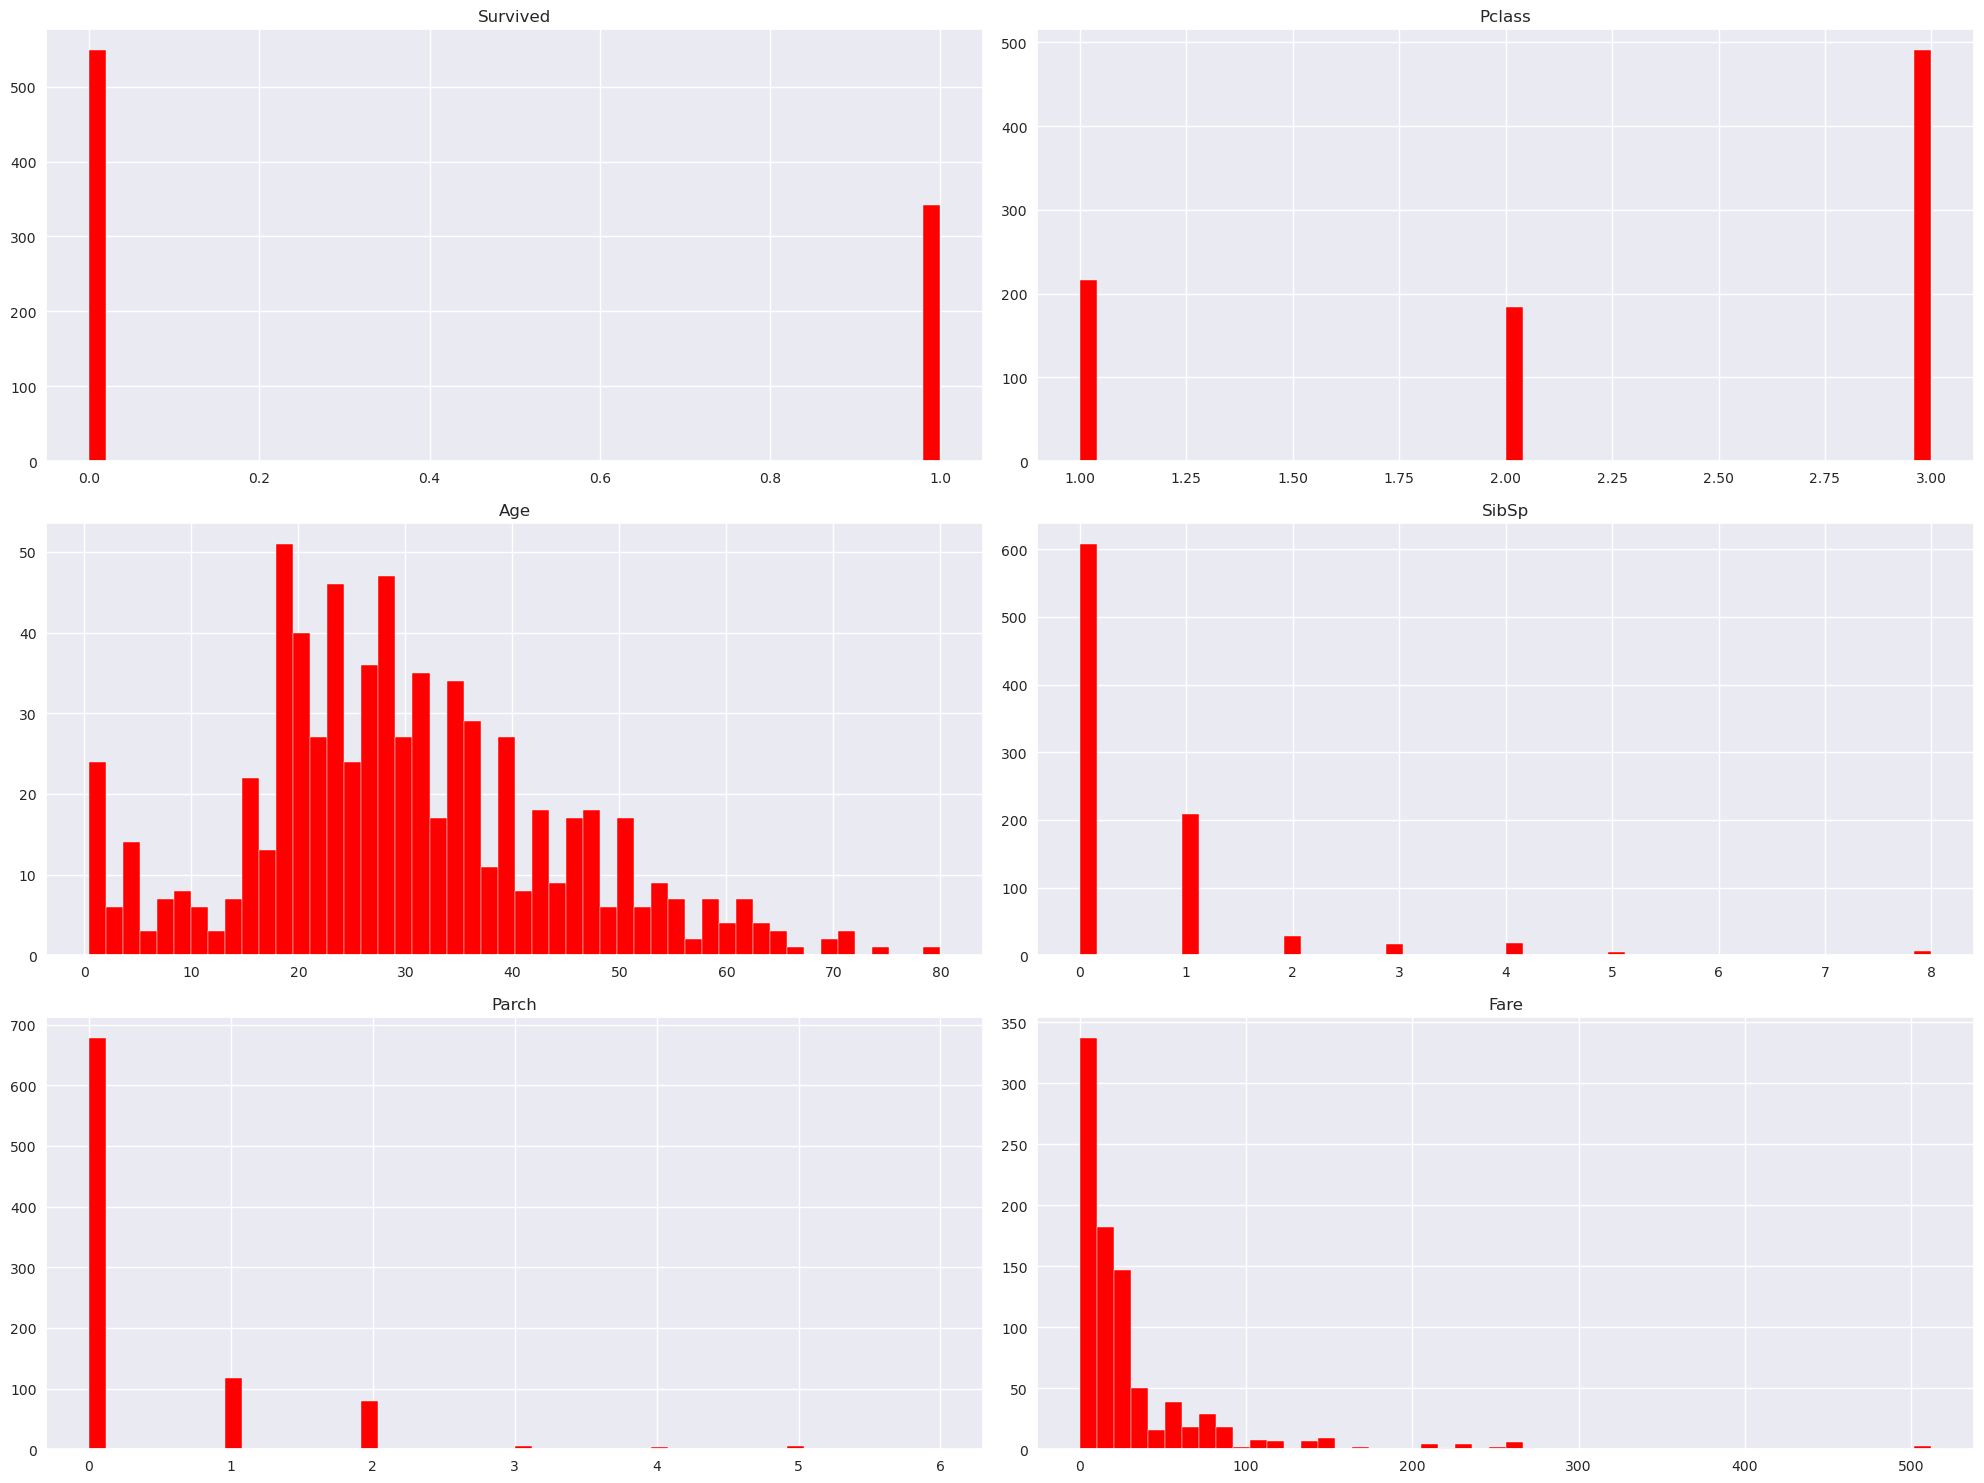

In [54]:
preprocessing.histogram_graphs()

In [55]:
preprocessing.inconsistent_data()

Column Survived has no inconsistent values
Column Pclass has no inconsistent values
Column Age has no inconsistent values
Column SibSp has no inconsistent values
Column Parch has no inconsistent values
Column Fare has no inconsistent values


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,female,19.0,0,0,112053,30.0000,B42,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,male,26.0,0,0,111369,30.0000,C148,C


In [56]:
preprocessing.missing_data()

Missing data: 
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64


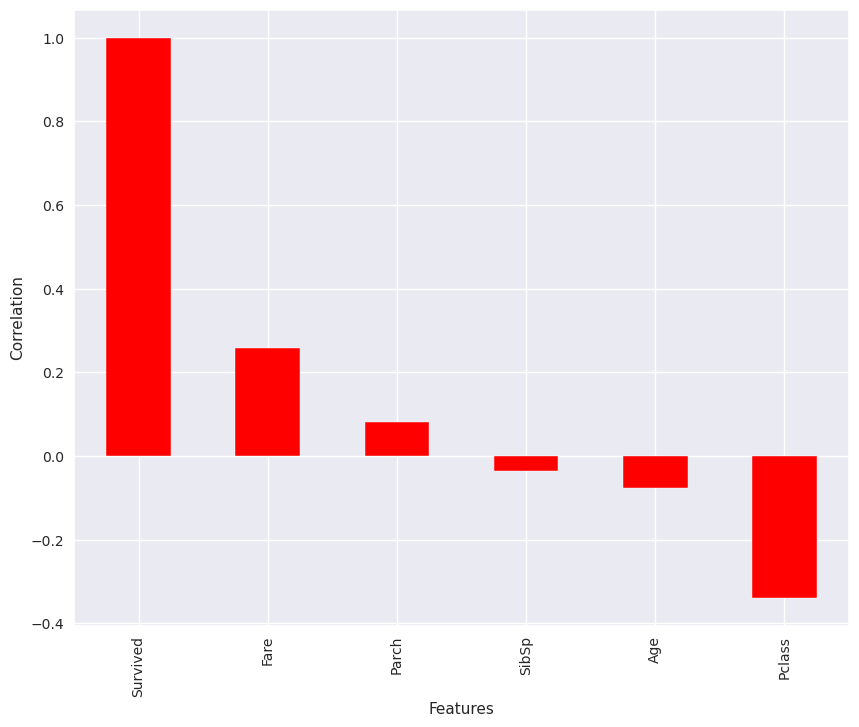

In [57]:
preprocessing.correlation_matrix()

In [58]:
preprocessing.dynamic_graph()

In [59]:
preprocessing.boxplots_graphs()

In [60]:
preprocessing.train["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [61]:
preprocessing.removing_outliers()

In [62]:
preprocessing.splitting_data()

In [63]:
preprocessing.update_columns_type()

In [64]:
preprocessing.pipelines_transformation()

Pipeline has been saved


In [65]:
train_model = TrainRFC()
train_model.evaluate_models()
train_model.train_model()
train_model.get_important_features()


,Model,AUC Mean,AUC Std
0,RandomForestClassifier,0.841,0.04
1,SVC,0.841,0.05
2,LogisticRegression,0.840,0.05
3,KNeighborsClassifier,0.832,0.04


Sex                           : 0.475
Fare                          : 0.322
Pclass                        : 0.115
Age                           : 0.087


In [66]:
train_model.select_best_hyperparameters()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyperparameters: {'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 300}


Accuracy : 0.8153
Precision: 0.8000
Recall   : 0.6234
AUC      : 0.8734


/home/gabriel-caetano/miniconda3/envs/env/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



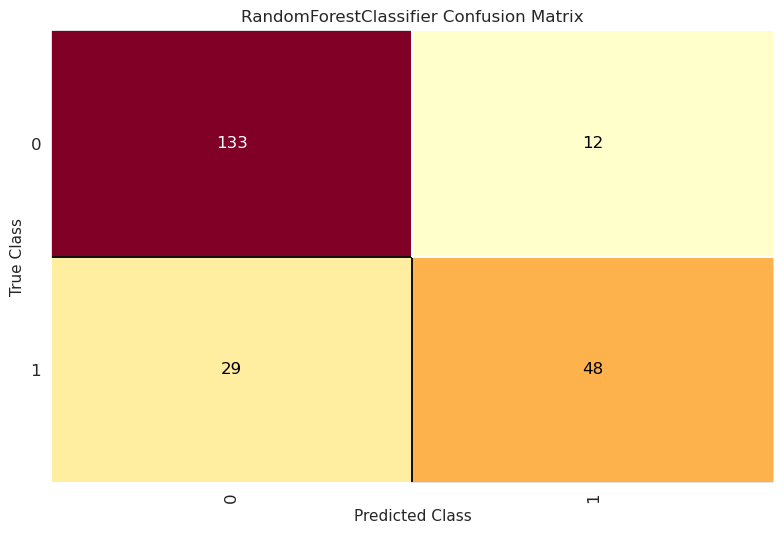

In [67]:
train_model.evaluate_best_random_forest_model()

# Test Dataset

In [68]:
class TestPreprocessing(Preprocessing):
    # Verifying inconsistent values
    def inconsistent_data(self):
        for column in self.numeric_columns_test.columns:
            inconsistent_values = self.test.loc[self.test[column] < 0]
            if inconsistent_values.empty:
                print(f"Column {column} has no inconsistent values")
            else:
                print(f"Column {column} has inconsistent values")

        return self.test

    # Verifying missing data
    def missing_data(self):
        print(self.test.isnull().sum())

        # Replacing the missing values in numerical columns with the mean
        self.test[self.numeric_columns_test.columns] = self.train[self.numeric_columns_test.columns].apply(lambda column: column.fillna(column.mean()))
        # Replacing the missing data in categorical columns as 'Unknown'
        self.test[self.categorical_columns_test.columns] = self.train[self.categorical_columns_test.columns].fillna("Unknown")

        return self.test


In [69]:
test_preprocessing = TestPreprocessing()
test_preprocessing.test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,3,female,47.0,1,0,363272,7.0000,NaN,S
2,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,3,male,27.0,0,0,315154,8.6625,NaN,S
4,3,female,22.0,1,1,3101298,12.2875,NaN,S
5,3,male,14.0,0,0,7538,9.2250,NaN,S
6,3,female,30.0,0,0,330972,7.6292,NaN,Q
7,2,male,26.0,1,1,248738,29.0000,NaN,S
8,3,female,18.0,0,0,2657,7.2292,NaN,C
9,3,male,21.0,2,0,A/4 48871,24.1500,NaN,S
